<a href="https://colab.research.google.com/github/SergioManuelJob/EarthquakePrediction/blob/master/EarthquakePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sergio Manuel Suárez Suárez

In [15]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, confusion_matrix
from lightgbm import LGBMClassifier

In [2]:
df_labels = pd.read_csv("https://raw.githubusercontent.com/SergioManuelJob/data/master/earthquake_train_labels.csv")
df_values = pd.read_csv("https://raw.githubusercontent.com/SergioManuelJob/data/master/earthquake_train_values.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/SergioManuelJob/data/master/earthquake_test_values.csv")

In [ ]:
def get_information(dataset):
  print(dataset.shape)
  print(dataset.info())
  return dataset.describe()

In [ ]:
get_information(df_values)

(260601, 39)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,5.256755e+05,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,0.018235,0.068154,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,0.983949,0.111880,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,3.045450e+05,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,0.133800,0.252010,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.418389,0.315219,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.611900e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.257570e+05,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.897620e+05,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Con este simple vistazo vemos los valores máximos y mínimos de las distintas variables, así como la naturaleza de ellas. Vemos que la mayoría de las variables son valores binarios de ser o no ser.

In [ ]:
# Vemos cómo está estructurado el dataframe de labels, para ver como unirlo con el dataframe de values
df_labels.head(3)

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3


In [3]:
df_values = pd.concat([df_values, df_labels['damage_grade']], axis=1)
df_values.head(5)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [4]:
# Nos deshacemos del id de los edificios ya que ya no nos interesa, se valora saber
# que de qué región es el edifico por su geo_level_id puede resultar interesante para el entrenamiento.
df_values = df_values.drop("building_id", axis = 1)
df_values.head(5)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


### Arreglo del dataset para nuestro estudio.

In [5]:
# Vamos a convertir todas las variables categóricas a número para poder utilizar metódos como la matriz de correlación
df_values['land_surface_condition'] = pd.factorize(df_values['land_surface_condition'])[0]
df_values['foundation_type'] = pd.factorize(df_values['foundation_type'])[0]
df_values['roof_type'] = pd.factorize(df_values['roof_type'])[0]
df_values['ground_floor_type'] = pd.factorize(df_values['ground_floor_type'])[0]
df_values['other_floor_type'] = pd.factorize(df_values['other_floor_type'])[0]
df_values['position'] = pd.factorize(df_values['position'])[0]
df_values['plan_configuration'] = pd.factorize(df_values['plan_configuration'])[0]
df_values['legal_ownership_status'] = pd.factorize(df_values['legal_ownership_status'])[0]
df_values.head(5)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,6,487,12198,2,30,6,5,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3
1,8,900,2812,2,10,8,7,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
2,21,363,8973,2,10,5,5,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3
3,22,418,10694,2,10,6,5,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
4,11,131,1488,3,30,8,9,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3


### Análisis de la correlación de las características.

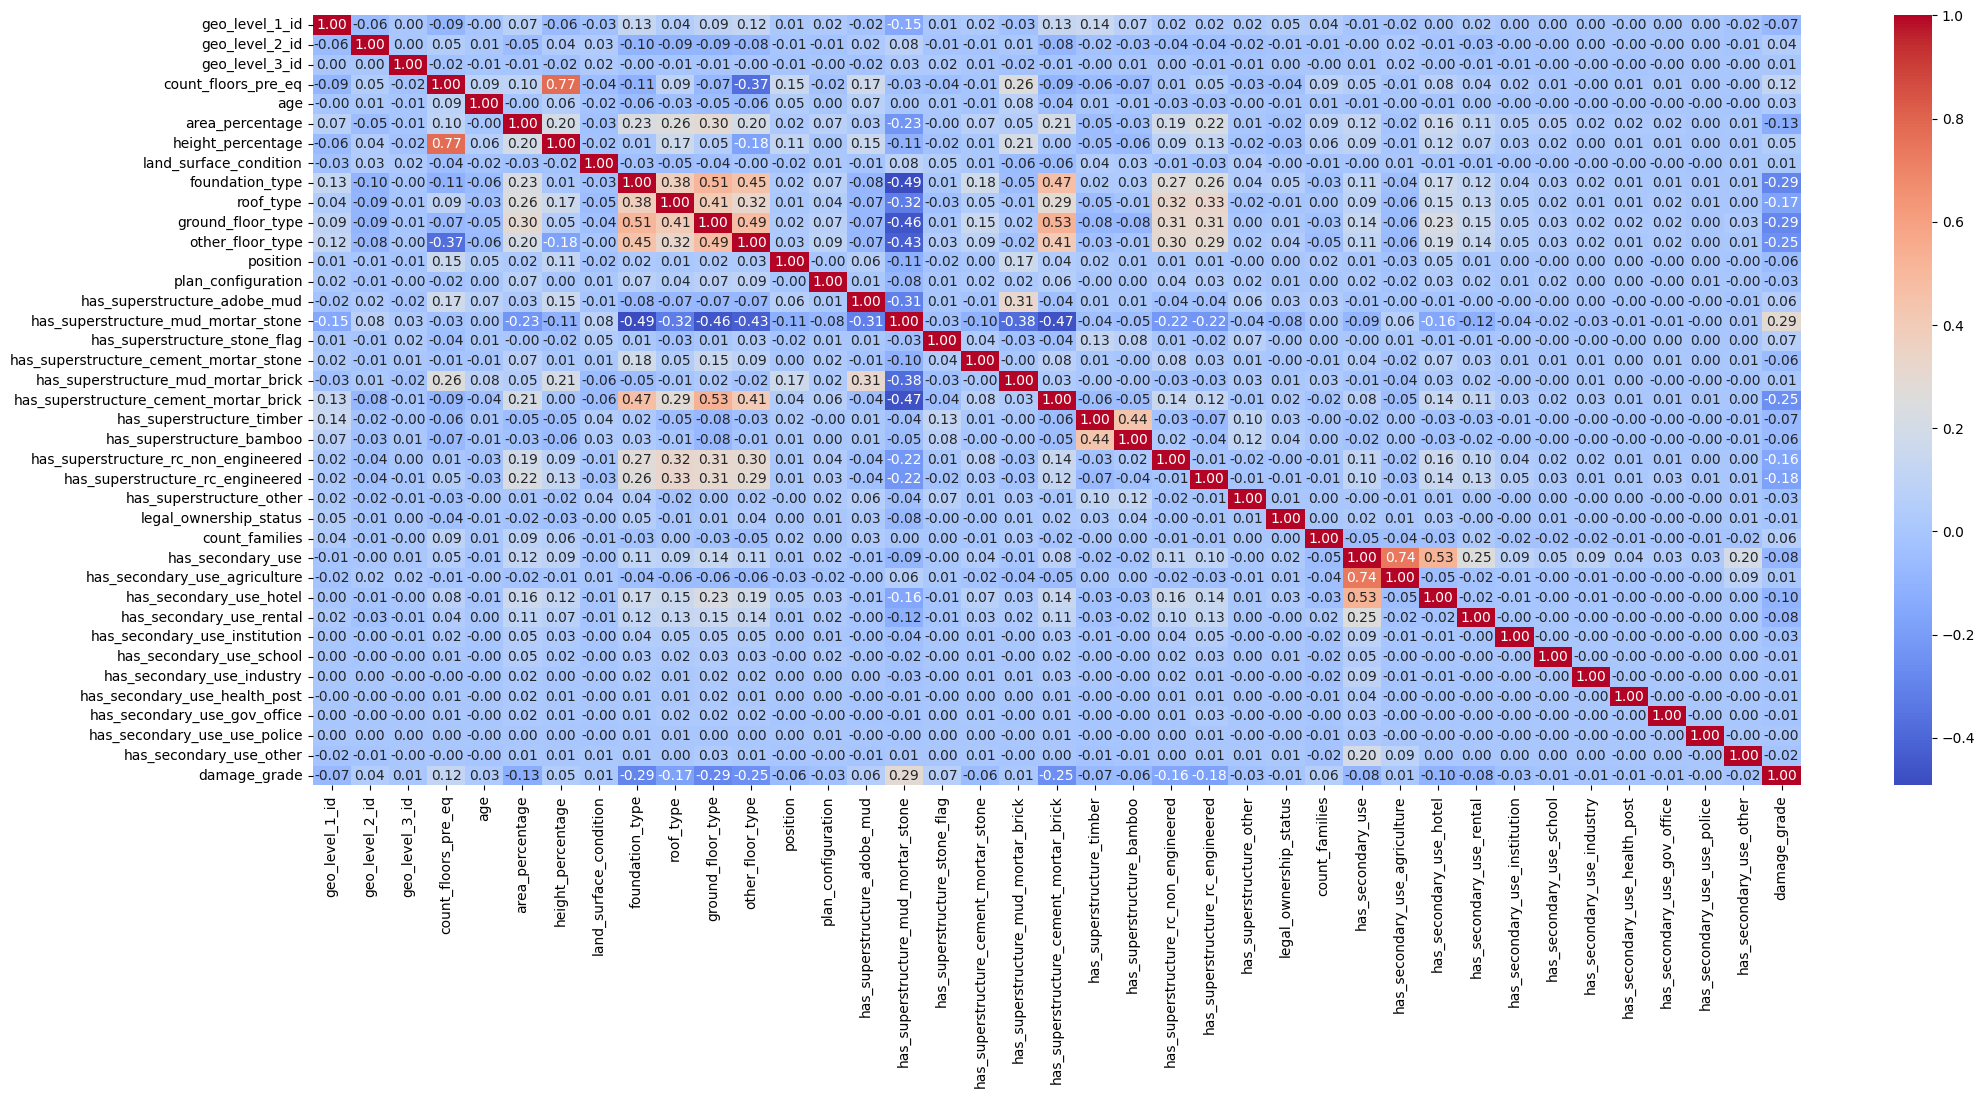

In [ ]:
plt.figure(figsize=(24, 10))
sns.heatmap(df_values.corr(), cmap = "coolwarm", annot = True, fmt=".2f")
plt.show()

En esta matriz de correlación observamos que no hay ninguna característica que esté muy relacionada con otra, al menos, no lo suficientemente fuerte como para descartarla con esta gráfica. Además, es muy interesante ver esta matriz de correlación, para tener en cuenta aquellas características que se relacionan con la variable "y", tanto relacionada de forma negativa como positiva. Y con eso observamos que hay unas cuantas,

Ahora es momento de reducir el dataset, ya que debido a su extensión da muchos problemas de ahora en adelante. Mi propuesta para reducir el dataset es sencilla, primero quiero ver cuántos casos de cada uno de los grados de daño hay, para intentar hacer un dataset lo menos sesgado posible.

<Axes: >

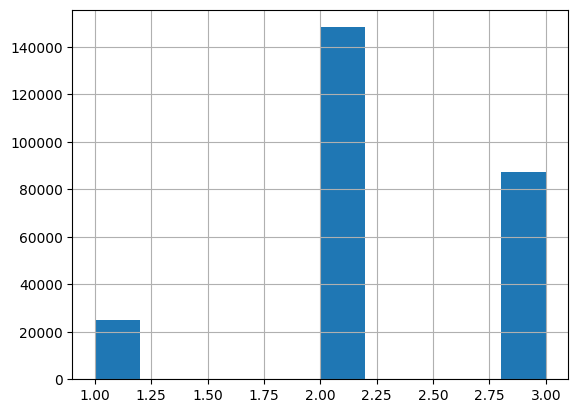

In [ ]:
df_values['damage_grade'].hist()

Vemos que el dataset original está muy sesgado, por lo que además le vamos a sacar beneficio a la reducción del dataset. Como ejemplo, voy a coger 20.000 filas de cada uno de los grados de daño, los voy a separar y juntar en mi dataset de entrenamiento final.

In [6]:
casos_por_grado = 20000

df_dg1 = df_values[df_values['damage_grade'] == 1].head(casos_por_grado)
df_dg2 = df_values[df_values['damage_grade'] == 2].head(casos_por_grado)
df_dg3 = df_values[df_values['damage_grade'] == 3].head(casos_por_grado)

df_training = pd.concat([df_dg1, df_dg2, df_dg3])

(60000, 39)


<Axes: >

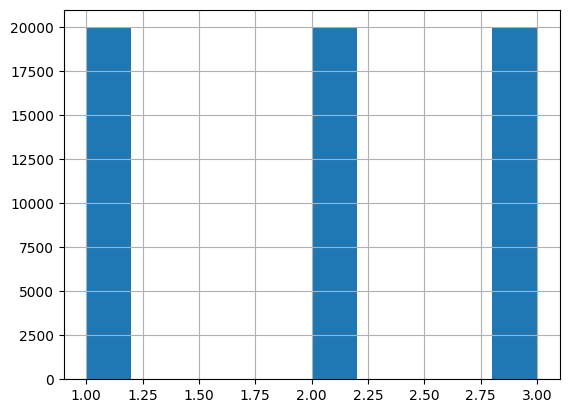

In [7]:
print(df_training.shape)
df_training['damage_grade'].hist()

Dividimos los datos en X e Y.

In [8]:
X = df_training.drop("damage_grade", axis=1)
y = df_training["damage_grade"]

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(


Distancia Media	 1397.83


<ipython-input-36-798458b11006>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = cluster.hierarchy.linkage(D, method='complete')


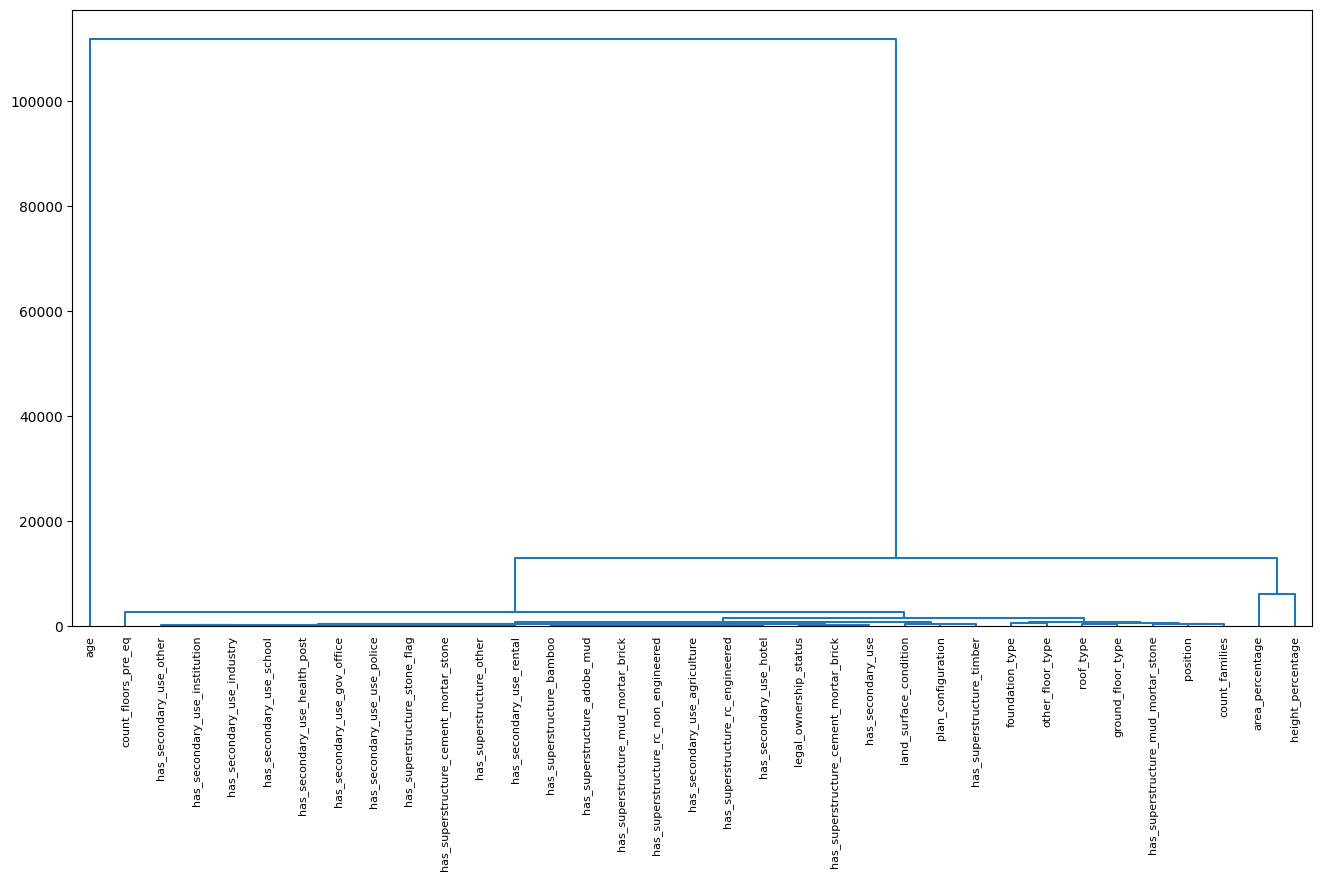

In [ ]:
import sklearn.neighbors
from scipy import cluster

dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
# Hacemos drop de los id de zona porque estos no van a tener relación con nada en principio
X_dist = X.drop(["geo_level_1_id", "geo_level_2_id", "geo_level_3_id"], axis=1)
D = dist.pairwise(X_dist.T)
avD = np.average(D)
print("Distancia Media\t {:6.2f}".format(avD))

plt.figure(figsize=(16, 8))
threshold_2 = 0.7
clusters = cluster.hierarchy.linkage(D, method='complete')
cluster.hierarchy.dendrogram(clusters, color_threshold=threshold_2, labels=X_dist.columns.to_list(), leaf_rotation=90)
plt.show()

Aquí vemos algo parecido a la matriz de correlación, donde muchas de las variables no están muy agrupadas entre sí, siendo de las que menos "age", y las que están más o menos agrupadas.

Dividimos los datos en datos de train y validation. En el caso de los datos de test, utilizaremos el dataset de test que nos da la competición.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Vamos a intentar sacar características de los datos del selectKBest.

In [ ]:
for i in range(1, 10, 1):
  selector = SelectKBest(score_func=f_classif, k=i)
  X_new = selector.fit_transform(X_train, y_train)

  selected_columns = X.columns[selector.get_support()]

  print("Características seleccionadas de la iteración:" + str(i))
  print(str(selected_columns) + "\n")

Características seleccionadas de la iteración:1
Index(['has_superstructure_mud_mortar_stone'], dtype='object')

Características seleccionadas de la iteración:2
Index(['foundation_type', 'has_superstructure_mud_mortar_stone'], dtype='object')

Características seleccionadas de la iteración:3
Index(['foundation_type', 'other_floor_type',
       'has_superstructure_mud_mortar_stone'],
      dtype='object')

Características seleccionadas de la iteración:4
Index(['foundation_type', 'ground_floor_type', 'other_floor_type',
       'has_superstructure_mud_mortar_stone'],
      dtype='object')

Características seleccionadas de la iteración:5
Index(['foundation_type', 'ground_floor_type', 'other_floor_type',
       'has_superstructure_mud_mortar_stone',
       'has_superstructure_cement_mortar_brick'],
      dtype='object')

Características seleccionadas de la iteración:6
Index(['foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
       'has_superstructure_mud_mortar_stone',


Una vez más, vemos como el resultado es muy parecido a aquellos más o menos relacionados con la característica "y" en la matriz de correalación. Estas variables, muchas de ellas me parecen lógicas y que tienen sentido, así que vamos a probar a entrenar con estas.

Vamos a ver cómo queda la matriz de correlación con el redimensiónamiento de la matriz de datos.

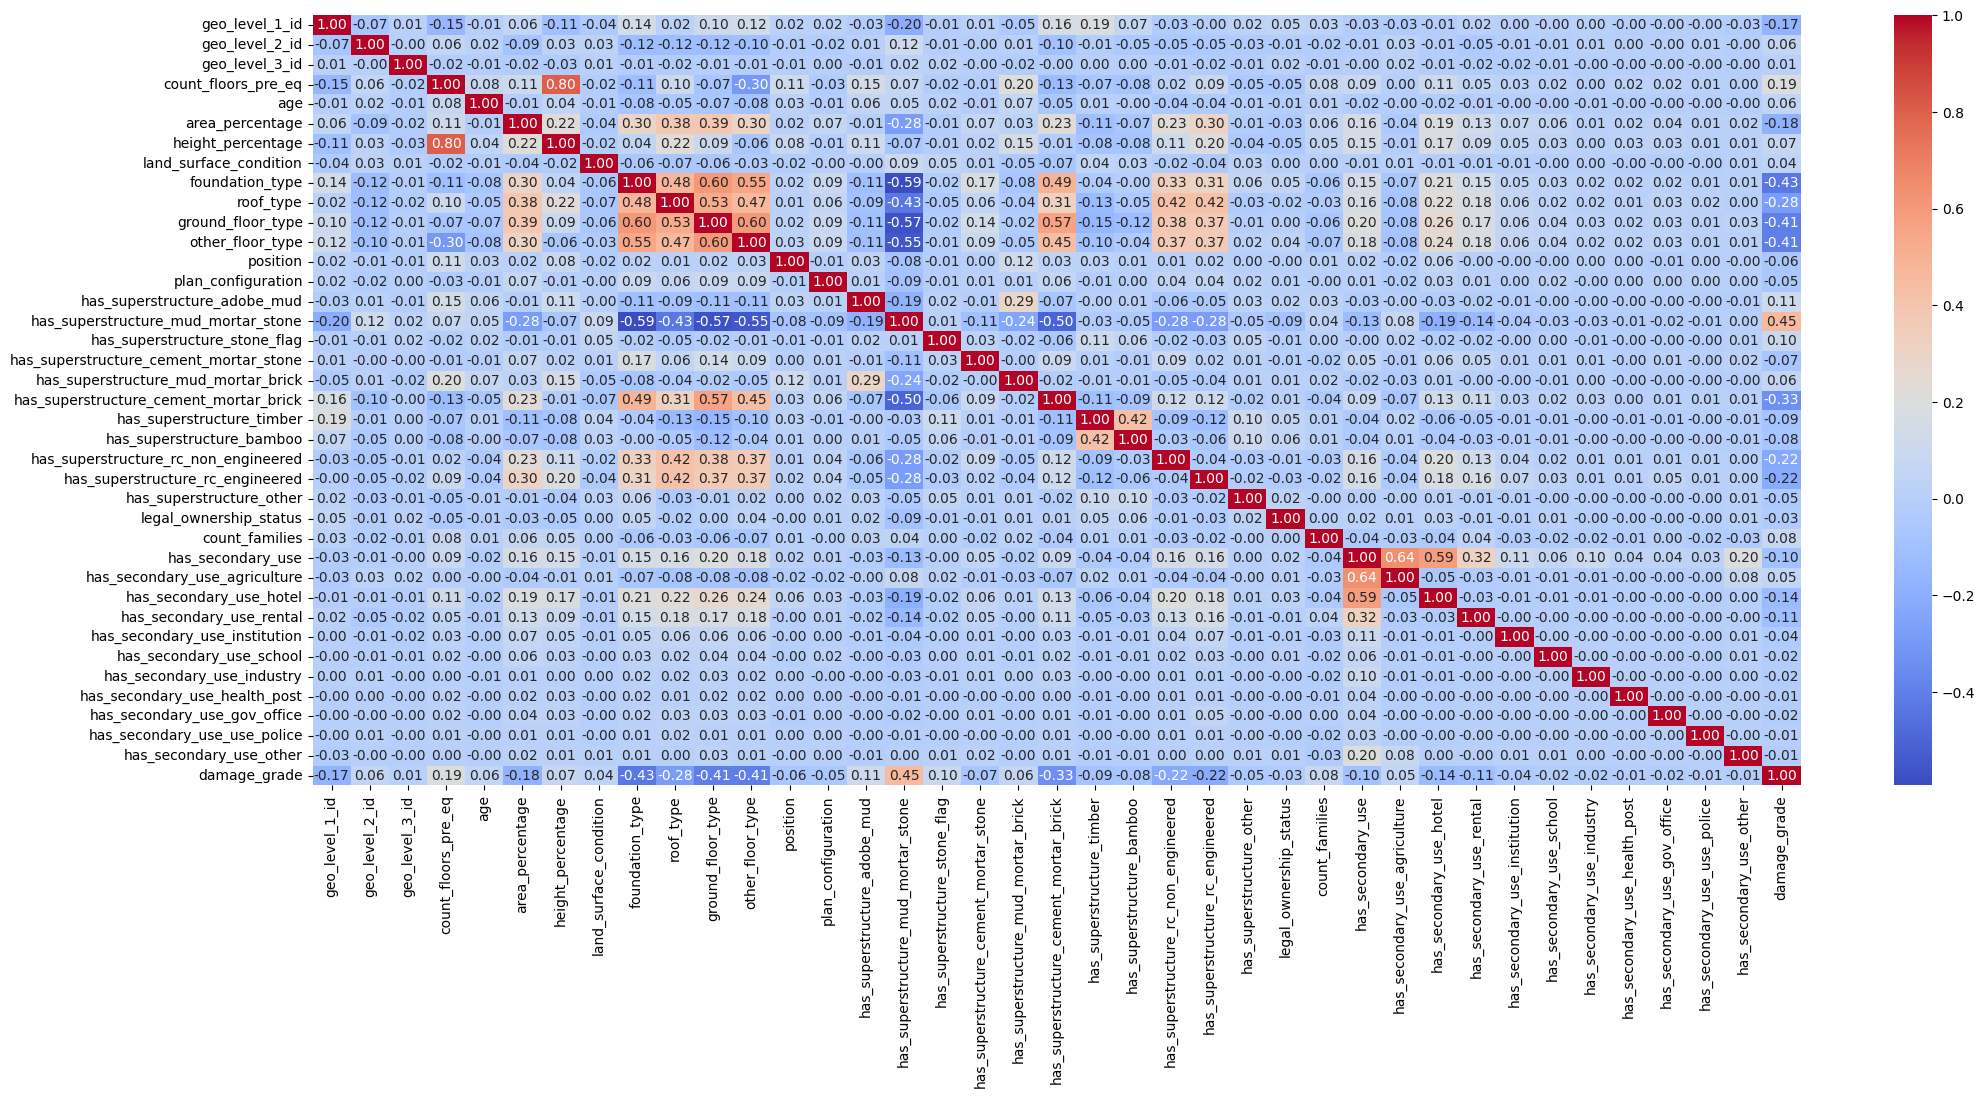

In [ ]:
plt.figure(figsize=(24, 10))
sns.heatmap(df_training.corr(), cmap = "coolwarm", annot = True, fmt=".2f")
plt.show()

Vemos la correlación antes descrita. Cuento al menos 13-14 variables que se correlacionan con la característica "y" de forma significativa, por lo que creo que voy a utilizar esa cantidad de variables en nuestra selección.

In [ ]:
  selector = SelectKBest(score_func=f_classif, k=14)
  X_new = selector.fit_transform(X_train, y_train)

  selected_columns = X.columns[selector.get_support()]

  print("Características seleccionadas de la iteración:" + str(i))
  print(str(selected_columns) + "\n")

Características seleccionadas de la iteración:9
Index(['geo_level_1_id', 'count_floors_pre_eq', 'area_percentage',
       'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_cement_mortar_brick',
       'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_secondary_use_hotel',
       'has_secondary_use_rental'],
      dtype='object')



In [10]:
selected_columns = ['geo_level_1_id', 'count_floors_pre_eq', 'area_percentage',
       'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_cement_mortar_brick',
       'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_secondary_use_hotel',
       'has_secondary_use_rental']

In [11]:
!pip install lazypredict
import lazypredict

In [12]:
from lazypredict.Supervised import LazyClassifier

# Le reduzco las dimensiones porque sino Colab da error por RAM
X_train_subset = X_train[selected_columns].iloc[:1500]
X_val_subset = X_val[selected_columns].iloc[:1500]

# X_train_subset = X_train.iloc[:1500]
# X_val_subset = X_val.iloc[:1500]

y_train_subset = y_train.iloc[:1500]
y_val_subset = y_val.iloc[:1500]

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_subset, X_val_subset, y_train_subset, y_val_subset)

print(models)

 90%|████████▉ | 26/29 [00:07<00:00,  3.62it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 1500, number of used features: 14
[LightGBM] [Info] Start training from score -1.110685
[LightGBM] [Info] Start training from score -1.059392
[LightGBM] [Info] Start training from score -1.127012


100%|██████████| 29/29 [00:07<00:00,  3.66it/s]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.63               0.63    None      0.63   
BaggingClassifier                  0.60               0.60    None      0.60   
AdaBoostClassifier                 0.59               0.59    None      0.59   
RandomForestClassifier             0.59               0.59    None      0.59   
KNeighborsClassifier               0.58               0.58    None      0.57   
ExtraTreesClassifier               0.57               0.57    None      0.57   
DecisionTreeClassifier             0.57               0.57    None      0.57   
SVC                                0.57               0.57    None      0.57   
ExtraTreeClassifier                0.56               0.56    None      0.56   
LabelSpreading                     0.55               0.55    None      0.55   
LabelPropagation                   0.55 

## Utilizamos el mejor modelo sacado por lazypredict.

In [ ]:
from lightgbm import LGBMClassifier

modelo_lgbm = LGBMClassifier()

# Definir los hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    'num_leaves': [20, 30, 40],
    'max_depth': [5, 7, 10],
}

grid_search = GridSearchCV(modelo_lgbm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train[selected_columns], y_train)

best_params_grid = grid_search.best_params_

print("Mejores hiperparámetros encontrados con GridSearchCV:")
print(best_params_grid)

param_dist = {
    'num_leaves': [20, 30, 40],
    'max_depth': [5, 7, 10],
}

random_search = RandomizedSearchCV(modelo_lgbm, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train[selected_columns], y_train)

best_params_random = random_search.best_params_

print("\nMejores hiperparámetros encontrados con RandomizedSearchCV:")
print(best_params_random)

best_model_grid = LGBMClassifier(**best_params_grid)
best_model_random = LGBMClassifier(**best_params_random)

best_model_grid.fit(X_train[selected_columns], y_train)
best_model_random.fit(X_train[selected_columns], y_train)

pred_val_grid = best_model_grid.predict(X_val[selected_columns])
pred_val_random = best_model_random.predict(X_val[selected_columns])

accuracy_val_grid = accuracy_score(y_val, pred_val_grid)
accuracy_val_random = accuracy_score(y_val, pred_val_random)

print("Precisión en el conjunto de validación con GridSearchCV:", accuracy_val_grid)
print("Precisión en el conjunto de validación con RandomizedSearchCV:", accuracy_val_random)

Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

Misma precisión para ambas búsquedas.

## Precisión del modelo: 67%~

Entrenamiento del modelo SVM.

In [13]:
modelo_svm = SVC()

param_grid = {
    'C': [0.5],
    'kernel': ['linear', 'rbf'],
}

grid_search = GridSearchCV(modelo_svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train[selected_columns], y_train)

best_params_grid = grid_search.best_params_

print("Mejores hiperparámetros encontrados con GridSearchCV:")
print(best_params_grid)

param_dist = {
    'C': [0.1, 0.5, 1],
    'kernel': ['linear', 'rbf'],
}

random_search = RandomizedSearchCV(modelo_svm, param_distributions=param_dist, n_iter=3, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train[selected_columns], y_train)

best_params_random = random_search.best_params_

print("\nMejores hiperparámetros encontrados con RandomizedSearchCV:")
print(best_params_random)

best_model_grid = SVC(**best_params_grid)
best_model_random = SVC(**best_params_random)

best_model_grid.fit(X_train[selected_columns], y_train)
best_model_random.fit(X_train[selected_columns], y_train)

pred_val_grid = best_model_grid.predict(X_val[selected_columns])
pred_val_random = best_model_random.predict(X_val[selected_columns])

accuracy_val_grid = accuracy_score(y_val, pred_val_grid)
accuracy_val_random = accuracy_score(y_val, pred_val_random)

print("Precisión en el conjunto de validación con GridSearchCV:", accuracy_val_grid)
print("Precisión en el conjunto de validación con RandomizedSearchCV:", accuracy_val_random)


Mejores hiperparámetros encontrados con RandomizedSearchCV:
{'kernel': 'rbf', 'C': 1}
Precisión en el conjunto de validación con GridSearchCV: 0.583
Precisión en el conjunto de validación con RandomizedSearchCV: 0.5816666666666667


Mejores hiperparámetros encontrados con GridSearchCV:
{'C': 0.5, 'kernel': 'rbf'}

Mejores hiperparámetros encontrados con RandomizedSearchCV:
{'kernel': 'rbf', 'C': 1}

## Precisión del modelo: 58%~

# Ahora voy a entrenar el modelo que mejores resultados me ha dado:

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Precisión del modelo: 0.66775


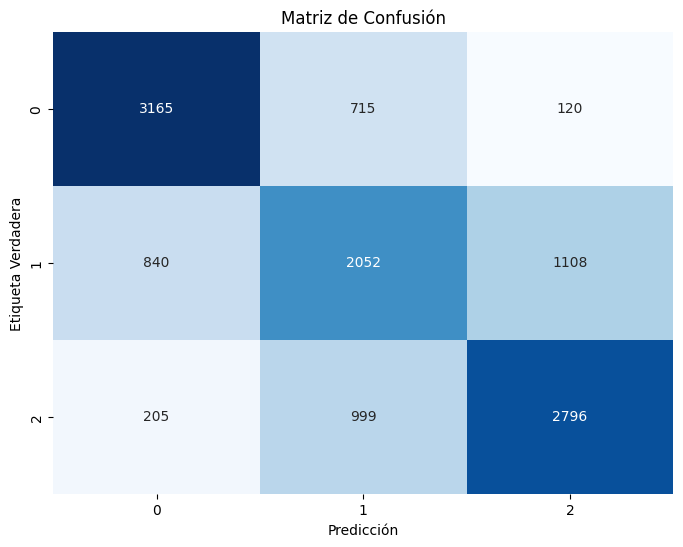

In [17]:
modelo_lgbm = LGBMClassifier(max_depth = 10, num_leaves = 40)
modelo_lgbm.fit(X_train[selected_columns], y_train)

pred_val = modelo_lgbm.predict(X_val[selected_columns])
accuracy = accuracy_score(y_val, pred_val)

print("Precisión del modelo:", accuracy)

matriz_confusion = confusion_matrix(y_val, pred_val)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')

plt.show()

La peor predicción es la de la clase 2, la cual en el dataset original tiene muchas más entradas y a lo mejor por el redimensionamiento hemos omitidos casos que el modelo no ha podido entrenar, aún así buenos resultados.

# Creación del submit

In [28]:
modelo_lgbm = LGBMClassifier(max_depth = 10, num_leaves = 40)
modelo_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 35
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier(max_depth=10, num_leaves=40)

In [29]:
submit_format = pd.read_csv('https://raw.githubusercontent.com/SergioManuelJob/data/master/earthquake_submission_format.csv')
submit_format

,building_id,damage_grade
0,300051,1
1,99355,1
2,890251,1
3,745817,1
4,421793,1
...,...,...
86863,310028,1
86864,663567,1
86865,1049160,1
86866,442785,1


Arreglo del dataset de test.

In [38]:
df_test['land_surface_condition'] = pd.factorize(df_test['land_surface_condition'])[0]
df_test['foundation_type'] = pd.factorize(df_test['foundation_type'])[0]
df_test['roof_type'] = pd.factorize(df_test['roof_type'])[0]
df_test['ground_floor_type'] = pd.factorize(df_test['ground_floor_type'])[0]
df_test['other_floor_type'] = pd.factorize(df_test['other_floor_type'])[0]
df_test['position'] = pd.factorize(df_test['position'])[0]
df_test['plan_configuration'] = pd.factorize(df_test['plan_configuration'])[0]
df_test['legal_ownership_status'] = pd.factorize(df_test['legal_ownership_status'])[0]
df_test.head(5)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,0,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [39]:
# Añade las predicciones como una nueva columna al DataFrame original
submit_format['damage_grade'] = modelo_lgbm.predict(df_test.drop('building_id', axis=1))
submit_format['damage_grade'] = submit_format['damage_grade'].astype(int)
# Muestra el DataFrame con las predicciones
submit_format

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3
...,...,...
86863,310028,2
86864,663567,3
86865,1049160,2
86866,442785,2


In [41]:
submit_format.to_csv('SubmitPredictionsEarthquake2.csv', index=False)